In [21]:
import os.path
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
# from gensim.downloader import load
# import gensim
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist #used to determine number of tokens

In [5]:
with open("goemotions.json", "r") as read_content:
    file = pd.read_json(read_content)

Taking count of all sentiment and emotion tags respectively associated with Reddit posts. Then creating a dictionary to create key-value pairings.

In [6]:
sentiment = file[2].value_counts().to_dict()
sentiment_values = sentiment.keys()
sentiment_frequency = sentiment.values()

In [7]:
emotion = file[1].value_counts().to_dict()
emotion_values = emotion.keys()
emotion_frequency = emotion.values()

In [39]:
# print(emotion_frequency)
p = list(emotion_frequency)
# print(p)
std = np.std(p)
print(std)

9860.333069673557


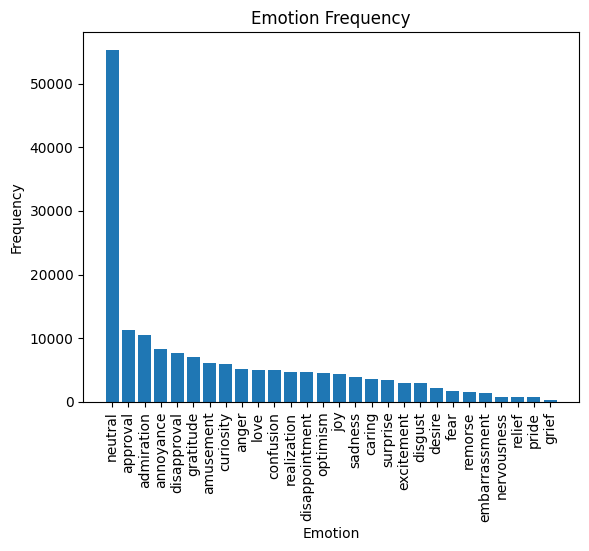

In [8]:
plt.xlabel("Emotion")
plt.ylabel("Frequency")
plt.title("Emotion Frequency")
plt.xticks(rotation= 90) #done for readbility purposes
plt.bar(emotion_values, emotion_frequency)
plt.savefig("bar_emotion.png")
plt.show()


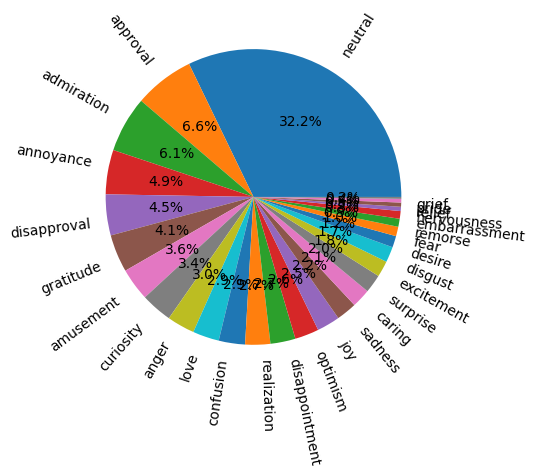

In [9]:
emotionLabels = []
sizes = []
for x, y in emotion.items():
    emotionLabels.append(x)
    sizes.append(y)
plt.pie(sizes, labels=emotionLabels, rotatelabels = True, autopct ='%1.1f%%')
plt.savefig("pie_emotion.png")
plt.show()


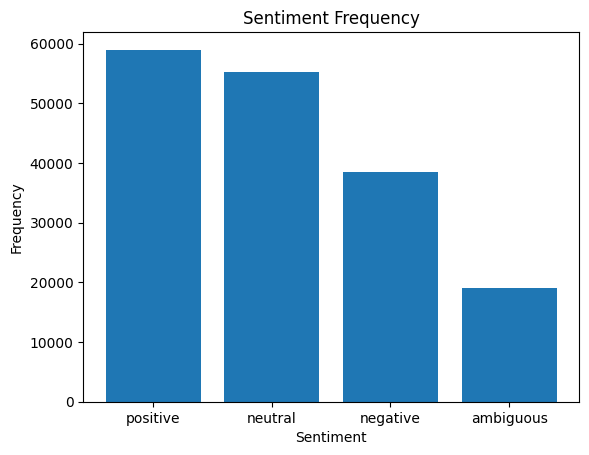

In [10]:
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.title("Sentiment Frequency")
plt.bar(sentiment_values, sentiment_frequency)
plt.savefig("bar_sentiment.png")
plt.show()

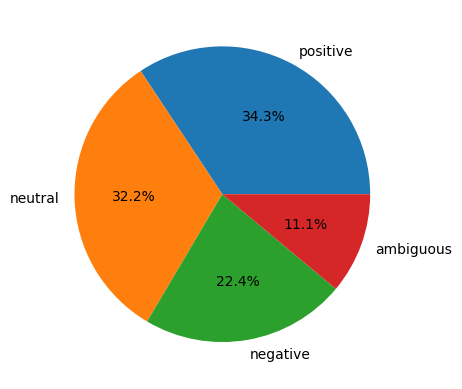

In [11]:
sentimentLabels = []
sizes = []
for x, y in sentiment.items():
    sentimentLabels.append(x)
    sizes.append(y)
plt.pie(sizes, labels=sentimentLabels, autopct ='%1.1f%%')
plt.savefig("pie_sentiment.png")
plt.show()


Plotting of Frequency vs. Emotion and Frequency vs. Sentiment <br>
Source: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html <br>
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html <br>
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html

<h1>extract tokens/words</h1>

In [12]:
post = file[0].tolist()
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(post)
# vectorizer.get_feature_names_out()

In [13]:
#print(f"The number of unique words is {len(X.toarray()[0])} unique words")

Given that when X.toarray() is used, the occurrences of words in a post is counted for example <br> "This document is the second document."<br> the word document is used twice [0 2 0 1 0 1 1 0 1] mapping to the array of unique words ['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
<br>
Sources: <br>
https://stackoverflow.com/questions/27488446/how-do-i-get-word-frequency-in-a-corpus-using-scikit-learn-countvectorizer
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [14]:
post = file[0]
vectorizer = CountVectorizer()
#vectorize posts into words that were used
# file[0] = vectorizer.fit_transform(post)
X = vectorizer.fit_transform(file[0])
# X_features =vectorizer.get_feature_names_out()

leEmo = preprocessing.LabelEncoder()
leSent = preprocessing.LabelEncoder()
#list(le.inverse_transform([2, 2, 1]))
encodedEmo = leEmo.fit_transform(file[1]) #change 0 to the column of emotions with no separation
#vectorize sentiments
encodedSentiment = leSent.fit_transform(file[2]) #change 0 to the column of sentiment with no separation

<h2>2.2 Training and Test data split</h2>

In [15]:
#Question 2.2
X_train,X_test,yemo_train, yemo_test,ysent_train, ysent_test = train_test_split(X,encodedEmo,encodedSentiment, test_size = 0.2, train_size=0.8)

In [13]:
def metrics(true_y,prediction_y):
    print(f"Accuracy for Emotion: {accuracy_score(y_true=true_y,y_pred= prediction_y)}")
    print(f"Precision (Weighted) for Emotion: {precision_score(y_true=true_y,y_pred= prediction_y, average='weighted')}")
    print(f"F1 Score (Weighted) for Emotion: {f1_score(y_true=true_y,y_pred= prediction_y,average='weighted')}")
    print(f"F1 Score (Macro) for Emotion: {f1_score(y_true=true_y,y_pred= prediction_y,average='macro')}")
    print(classification_report(y_true=true_y,y_pred= prediction_y, zero_division='warn'))
    confusion_matrix(y_true=true_y,y_pred= prediction_y)

<h2>Multinomial Naive Bayes Classifier (naive bayes.MultinomialNB.html)
with the default parameters.</h2>

Source: https://www.delftstack.com/howto/python/how-to-get-dictionary-keys-as-a-list-in-python/

In [17]:
classifier = MultinomialNB()
if (os.path.exists('models/MNB1_model.pickle')):
    pickle_in = open('models/MNB1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/MNB1_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/MNB2_model.pickle')):
    pickle_in = open('models/MNB2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/MNB2_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


Score for Emotion: 0.4377546269351647
Accuracy for Emotion: 0.4377546269351647
Precision (Weighted) for Emotion: 0.48387077148766455
F1 Score (Weighted) for Emotion: 0.3694720259898708
F1 Score (Macro) for Emotion: 0.22317735145571094


C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

              precision    recall  f1-score   support

           0       0.54      0.50      0.52      2120
           1       0.64      0.38      0.48      1243
           2       0.47      0.17      0.25       988
           3       0.42      0.14      0.21      1694
           4       0.43      0.16      0.23      2283
           5       0.45      0.10      0.17       684
           6       0.52      0.09      0.15       983
           7       0.54      0.16      0.25      1164
           8       0.56      0.05      0.09       427
           9       0.42      0.06      0.11       975
          10       0.44      0.14      0.22      1536
          11       0.66      0.13      0.22       576
          12       0.62      0.04      0.07       278
          13       0.54      0.08      0.13       584
          14       0.65      0.06      0.11       355
          15       0.78      0.70      0.74      1376
          16       0.00      0.00      0.00        58
          17       0.55    

/Users/jeffreychan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jeffreychan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


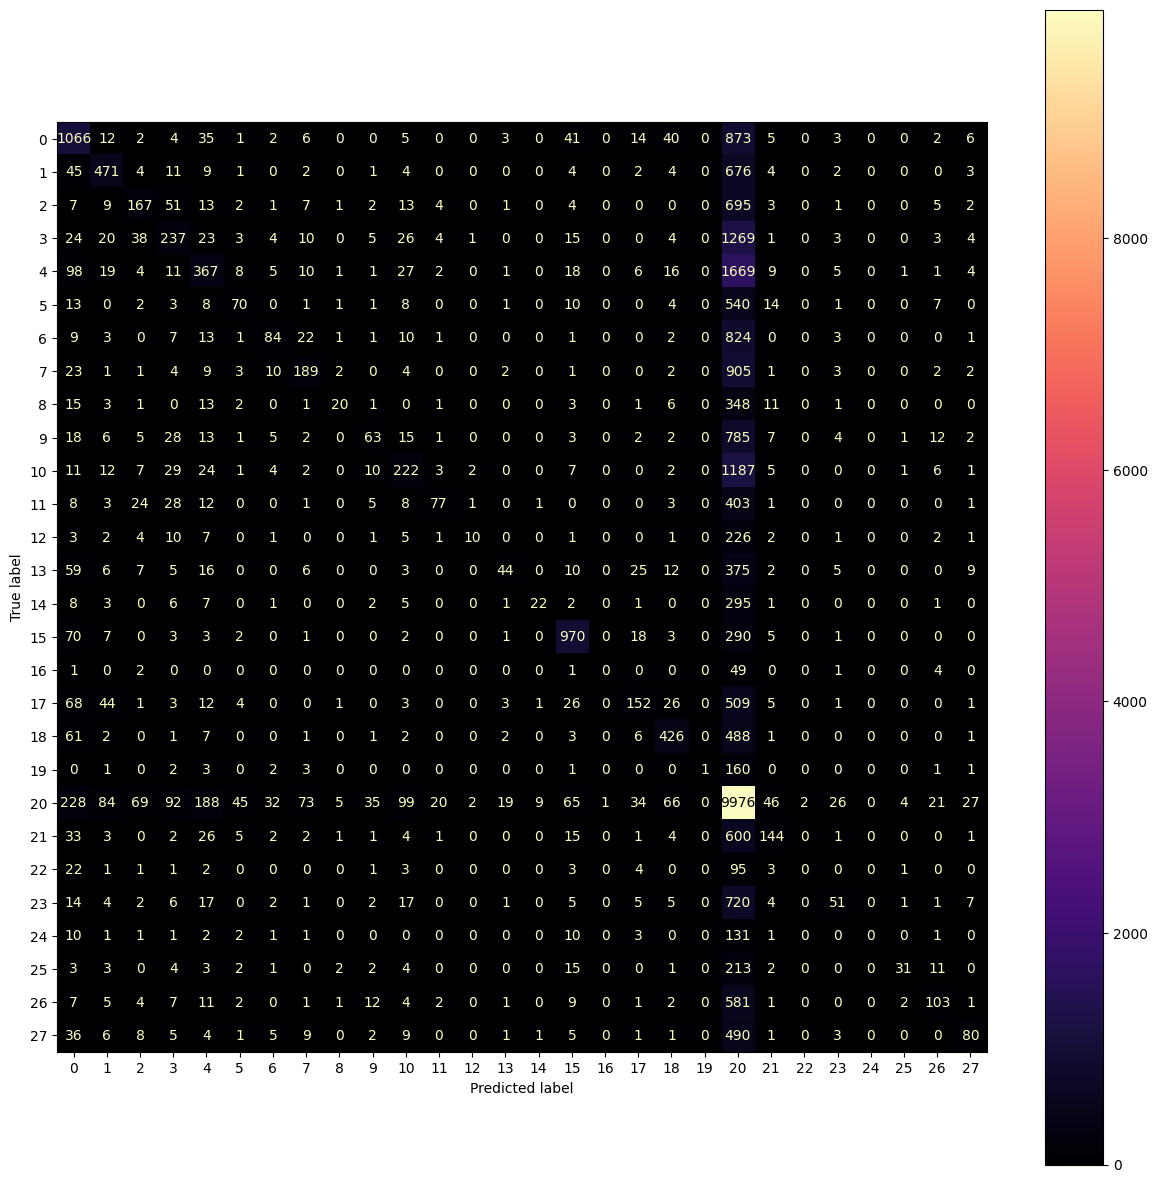

In [15]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test,yemo_test)}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Score for Sentiment: 0.6093295309044349
Accuracy for Emotion: 0.6093295309044349
Precision (Weighted) for Emotion: 0.6039268064719774
F1 Score (Weighted) for Emotion: 0.6025586774504342
F1 Score (Macro) for Emotion: 0.5670291790313071
              precision    recall  f1-score   support

           0       0.54      0.32      0.40      3680
           1       0.61      0.59      0.60      7689
           2       0.57      0.57      0.57     11268
           3       0.66      0.75      0.70     11727

    accuracy                           0.61     34364
   macro avg       0.59      0.56      0.57     34364
weighted avg       0.60      0.61      0.60     34364



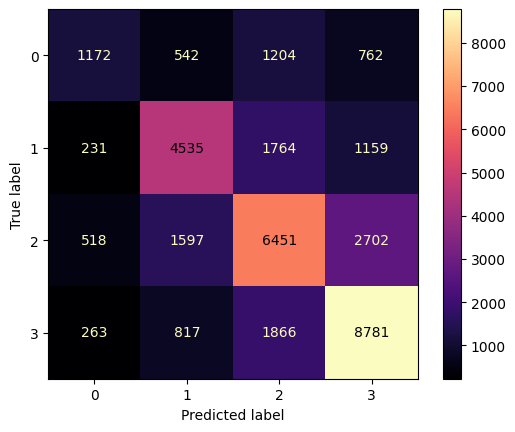

In [16]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test,ysent_test)}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>cross validation</h2>
<body>from sklearn.model_selection import cross_val_score</body>

<h2>Decision Tree (tree.DecisionTreeClassifier) with the default parameters.</h2>

In [17]:
classifier = DecisionTreeClassifier()
if (os.path.exists('models/DT1_model.pickle')):
    pickle_in = open('models/DT1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/DT1_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/DT1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)


if (os.path.exists('models/DT2_model.pickle')):

    pickle_in = open('models/DT2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/DT2_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/DT2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


Score for Emotion: 0.5956233267372832
Accuracy for Emotion: 0.5956233267372832
Precision (Weighted) for Emotion: 0.6113407936101686
F1 Score (Weighted) for Emotion: 0.5923691113436849
F1 Score (Macro) for Emotion: 0.5130949131505991
              precision    recall  f1-score   support

           0       0.57      0.81      0.67      2120
           1       0.60      0.81      0.69      1243
           2       0.45      0.74      0.56       988
           3       0.40      0.58      0.47      1694
           4       0.47      0.58      0.52      2283
           5       0.47      0.55      0.51       684
           6       0.48      0.58      0.53       983
           7       0.55      0.59      0.57      1164
           8       0.50      0.55      0.53       427
           9       0.46      0.45      0.46       975
          10       0.52      0.47      0.50      1536
          11       0.55      0.42      0.48       576
          12       0.50      0.39      0.44       278
          

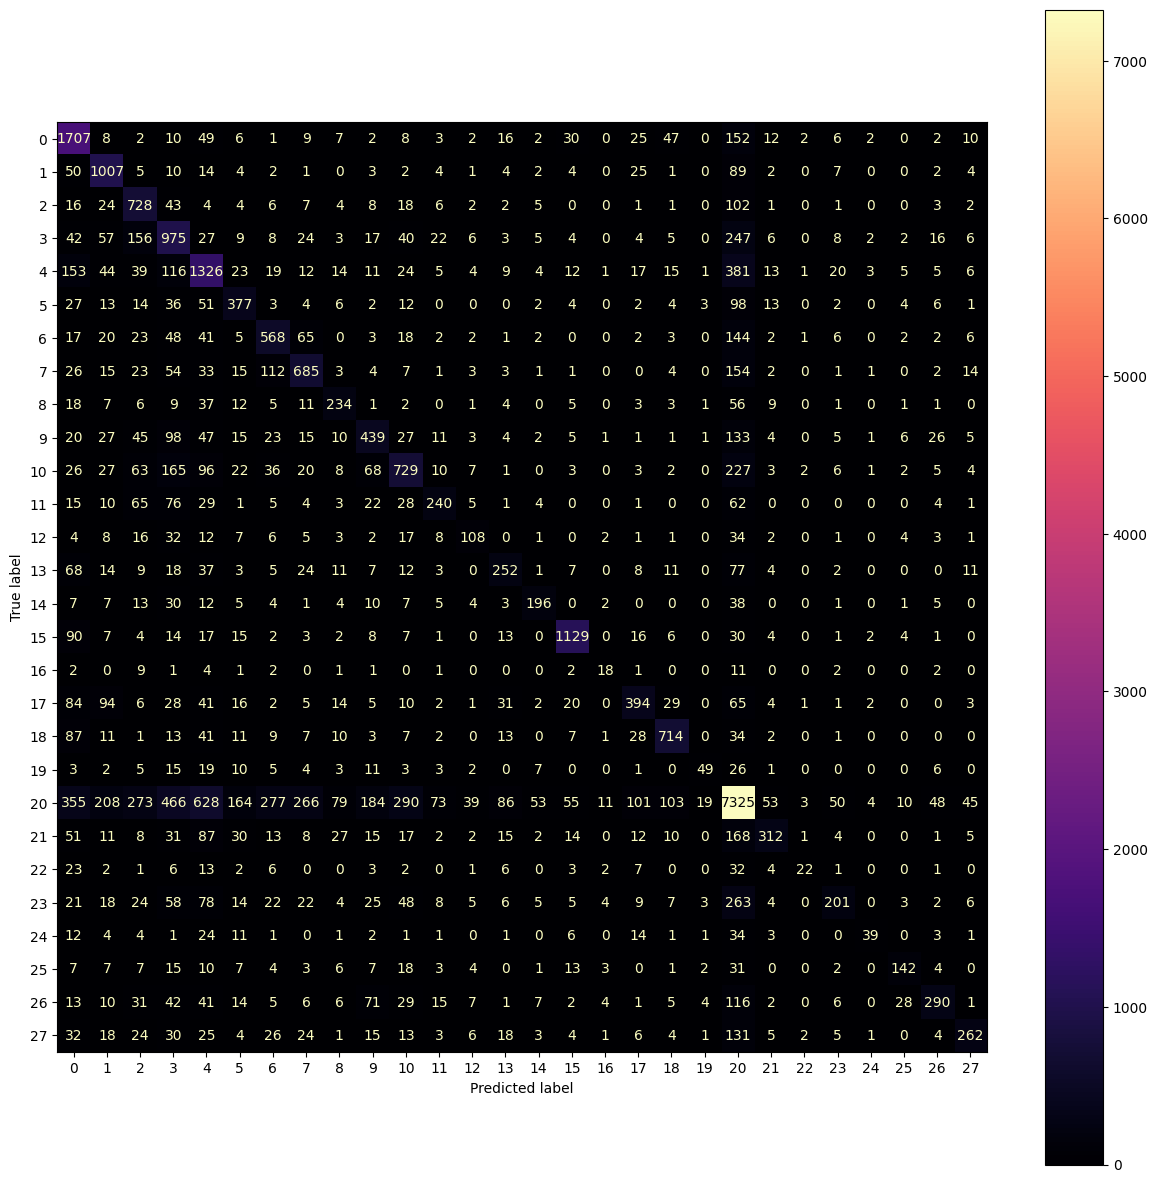

In [18]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test,yemo_test)}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')


Score for Sentiment: 0.7212489814922594
Accuracy for Emotion: 0.7212489814922594
Precision (Weighted) for Emotion: 0.7335354603955607
F1 Score (Weighted) for Emotion: 0.723791330959313
F1 Score (Macro) for Emotion: 0.706413721194035
              precision    recall  f1-score   support

           0       0.55      0.71      0.62      3680
           1       0.67      0.78      0.72      7689
           2       0.72      0.67      0.69     11268
           3       0.84      0.74      0.79     11727

    accuracy                           0.72     34364
   macro avg       0.70      0.72      0.71     34364
weighted avg       0.73      0.72      0.72     34364



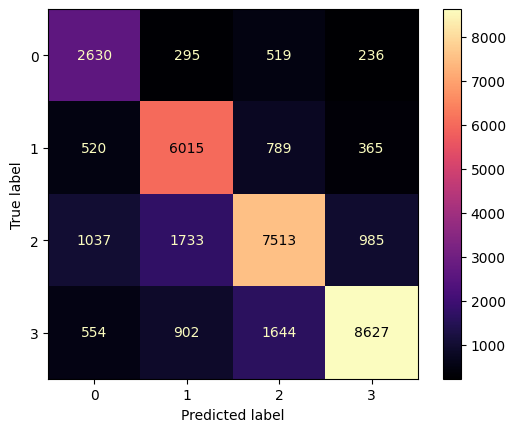

In [19]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test,ysent_test)}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron (neural network.MLPClassifier) with the default parameters.</h2>

In [20]:
classifier = MLPClassifier()
if (os.path.exists('models/MLP1_model.pickle')):
    pickle_in = open('models/MLP1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    MLP1 = classifier.fit(X_train, yemo_train)
    with open('models/MLP1_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/MLP1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/MLP2_model.pickle')):
    pickle_in = open('models/MLP2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    MLP2 = classifier.fit(X_train,ysent_train)
    with open('models/MLP2_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/MLP2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


Score for Emotion: 0.577231986963101
Accuracy for Emotion: 0.577231986963101
Precision (Weighted) for Emotion: 0.571306619799877
F1 Score (Weighted) for Emotion: 0.5720126636036188
F1 Score (Macro) for Emotion: 0.5007857804200834
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      2120
           1       0.65      0.68      0.66      1243
           2       0.52      0.51      0.52       988
           3       0.47      0.41      0.44      1694
           4       0.50      0.41      0.45      2283
           5       0.47      0.43      0.45       684
           6       0.48      0.44      0.46       983
           7       0.56      0.49      0.52      1164
           8       0.43      0.56      0.49       427
           9       0.43      0.36      0.39       975
          10       0.47      0.47      0.47      1536
          11       0.49      0.46      0.47       576
          12       0.44      0.46      0.45       278
          13 

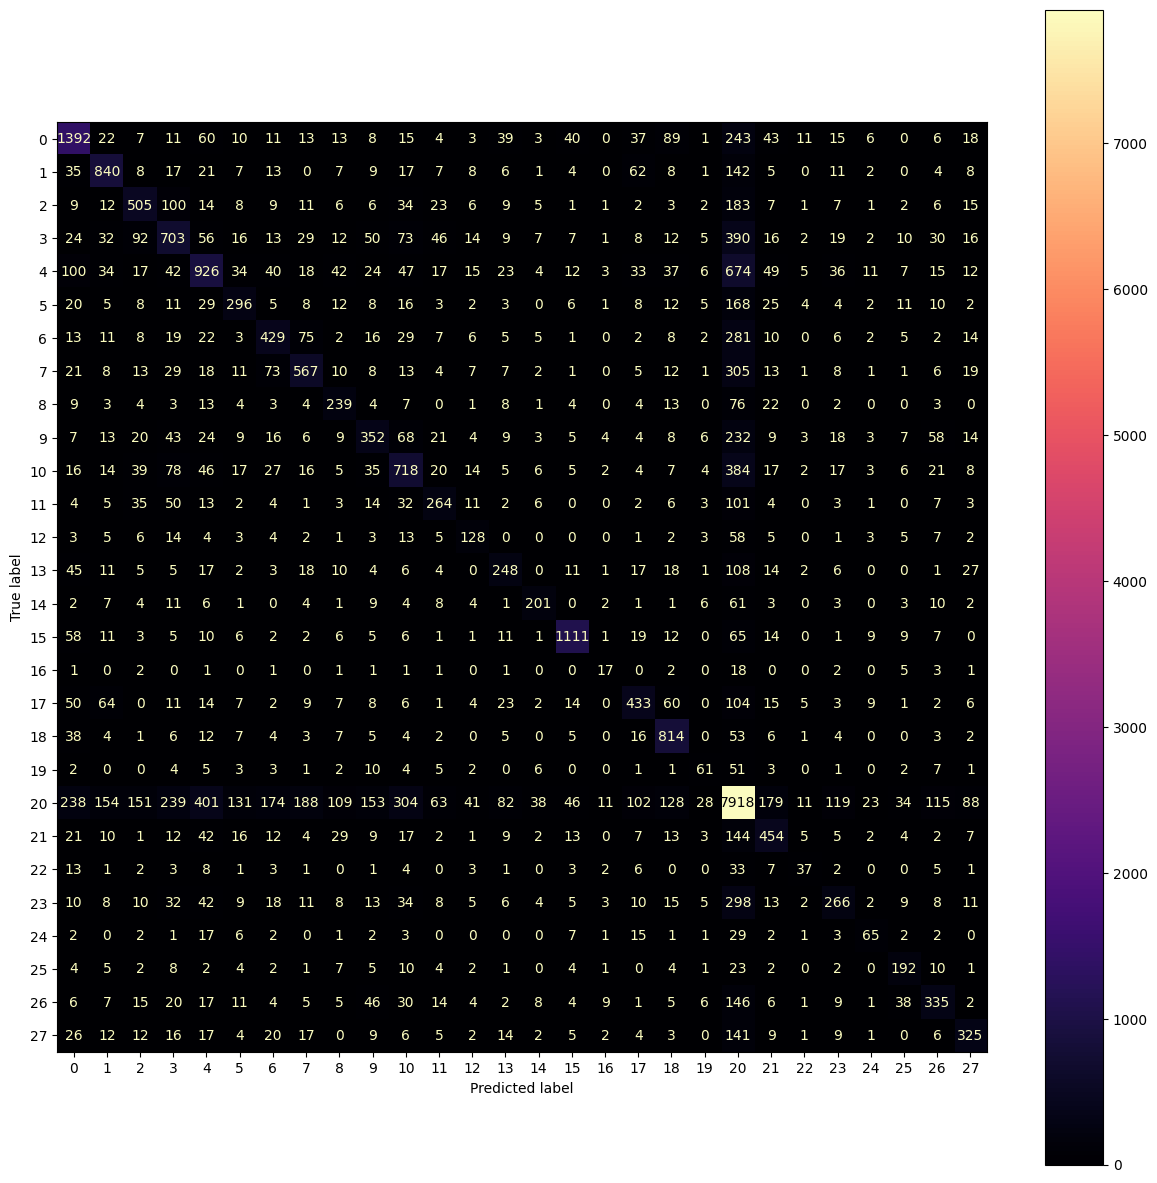

In [21]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test,yemo_test)}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Score for Sentiment: 0.5632056803631708
Accuracy for Emotion: 0.5632056803631708
Precision (Weighted) for Emotion: 0.56826643702058
F1 Score (Weighted) for Emotion: 0.547315212428697
F1 Score (Macro) for Emotion: 0.48476067220785735
              precision    recall  f1-score   support

           0       0.52      0.13      0.20      3680
           1       0.57      0.46      0.51      7689
           2       0.48      0.65      0.55     11268
           3       0.67      0.69      0.68     11727

    accuracy                           0.56     34364
   macro avg       0.56      0.48      0.48     34364
weighted avg       0.57      0.56      0.55     34364



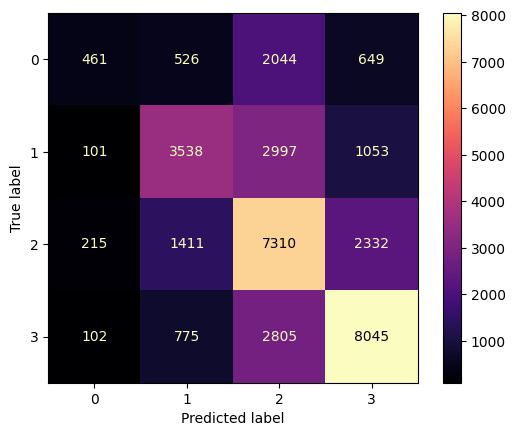

In [22]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test,ysent_test)}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multinomial Naive Bayes Classifier found using GridSearchCV</h2>

input parameter requires a model object

using the following alpha parameters 0.5,0,0.36,1


In [23]:
parameters = {"alpha":(0.5,0,0.36,1)}
clfMNB = MultinomialNB()

classifier = GridSearchCV(estimator=clfMNB, param_grid=parameters,n_jobs=-1)

if (os.path.exists('models/MNB1GridCV_model.pickle')):
    pickle_in = open('models/MNB1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/MNB1GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/MNB2GridCV_model.pickle')):
    pickle_in = open('models/MNB2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/MNB2GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


Best estimator (Emotion): MultinomialNB(alpha=0.36), Best Score: 0.3834754477508645
Accuracy for Emotion: 0.48507158654405774
Precision (Weighted) for Emotion: 0.47853381176328486
F1 Score (Weighted) for Emotion: 0.45966059482335553
F1 Score (Macro) for Emotion: 0.35639970039487057
              precision    recall  f1-score   support

           0       0.53      0.58      0.56      2120
           1       0.61      0.62      0.61      1243
           2       0.46      0.35      0.40       988
           3       0.41      0.25      0.31      1694
           4       0.41      0.25      0.31      2283
           5       0.36      0.30      0.33       684
           6       0.44      0.27      0.33       983
           7       0.48      0.33      0.39      1164
           8       0.52      0.25      0.34       427
           9       0.41      0.19      0.26       975
          10       0.41      0.29      0.34      1536
          11       0.50      0.30      0.37       576
          12  

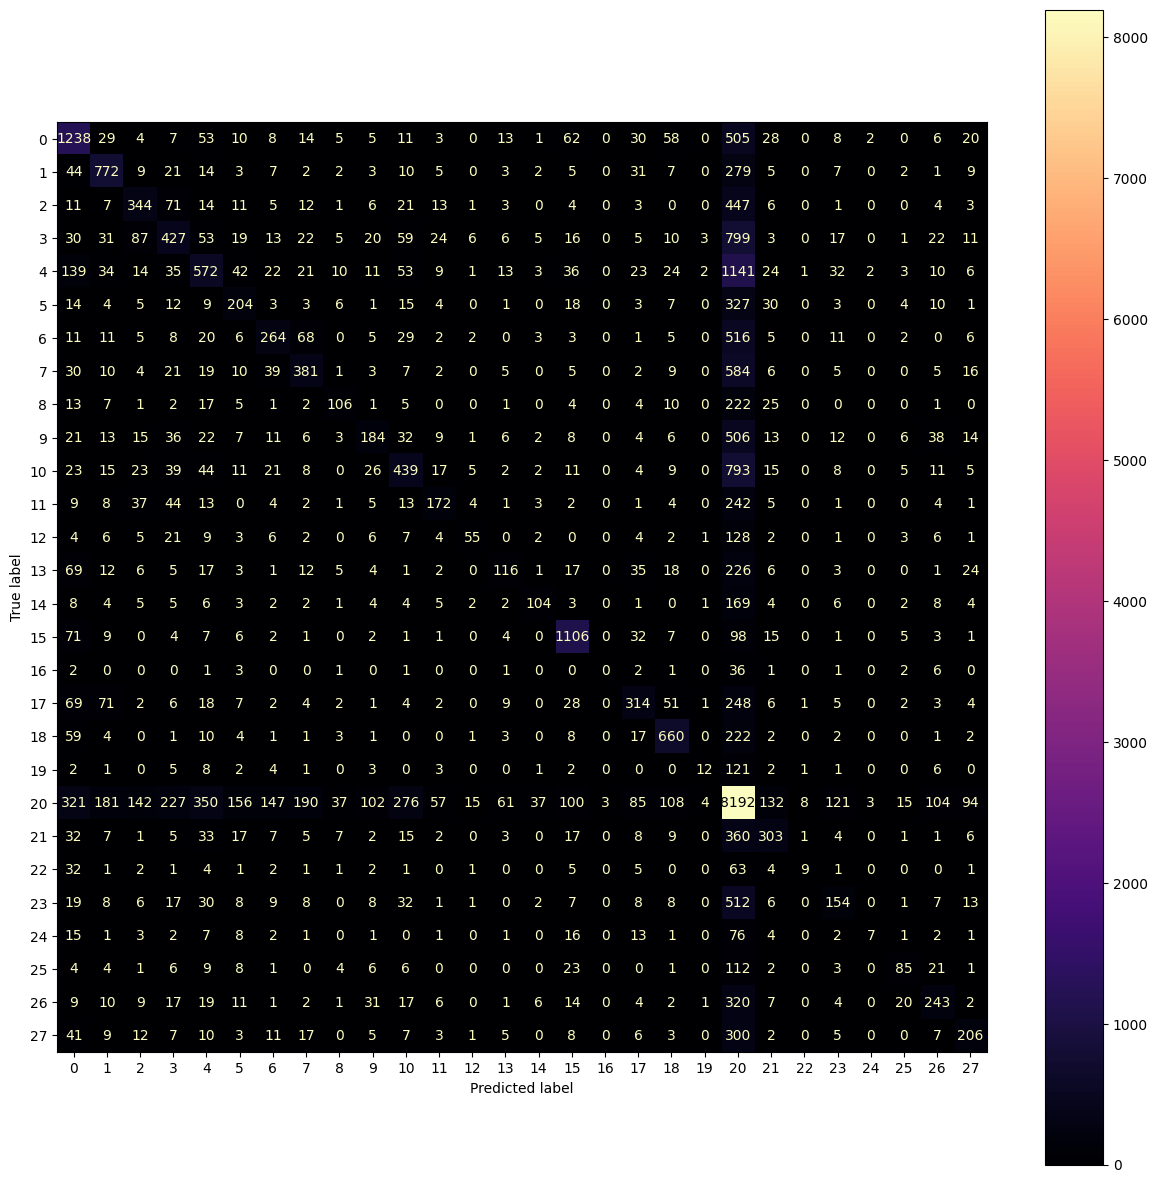

In [24]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Best estimator (Sentiment): MultinomialNB(alpha=1), Best Score: 0.5383904367141189
Accuracy for Emotion: 0.6113665463857525
Precision (Weighted) for Emotion: 0.6058933835057612
F1 Score (Weighted) for Emotion: 0.6047857898391407
F1 Score (Macro) for Emotion: 0.5695173358443237
              precision    recall  f1-score   support

           0       0.54      0.32      0.40      3680
           1       0.60      0.60      0.60      7689
           2       0.57      0.57      0.57     11268
           3       0.66      0.75      0.70     11727

    accuracy                           0.61     34364
   macro avg       0.59      0.56      0.57     34364
weighted avg       0.61      0.61      0.60     34364



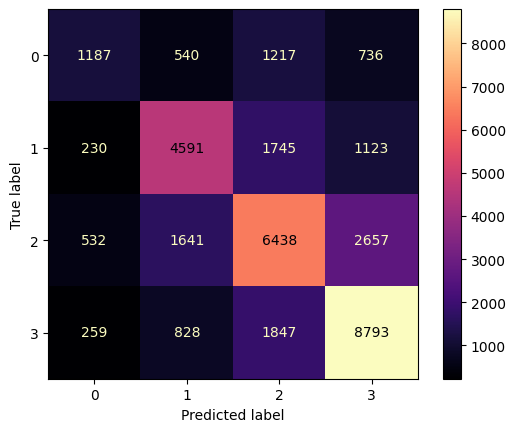

In [25]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Decision Tree Classifier found using GridSearchCV</h2>

input parameter requires a model object

using the various value for the following parameters: criterion, max_depth, min_samples


In [26]:
parameters = {"criterion":("gini","entropy"),"max_depth":(100,3),"min_samples_split":(12,5,30)}
clfDT = DecisionTreeClassifier()

classifier = GridSearchCV(estimator=clfDT, param_grid=parameters,n_jobs=-1)

if (os.path.exists('models/DT1GridCV_model.pickle')):
    pickle_in = open('models/DT1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/DT1GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/DT1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/DT2GridCV_model.pickle')):
    pickle_in = open('models/DT2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/DT2GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/DT2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


Best estimator (Emotion): DecisionTreeClassifier(max_depth=100, min_samples_split=30), Best Score: 0.4044639513068846
Accuracy for Emotion: 0.5069840530788035
Precision (Weighted) for Emotion: 0.5069477641706425
F1 Score (Weighted) for Emotion: 0.4645937360774832
F1 Score (Macro) for Emotion: 0.3646085842014283
              precision    recall  f1-score   support

           0       0.58      0.55      0.56      2120
           1       0.64      0.68      0.66      1243
           2       0.47      0.35      0.40       988
           3       0.38      0.20      0.26      1694
           4       0.42      0.18      0.25      2283
           5       0.43      0.20      0.27       684
           6       0.45      0.24      0.32       983
           7       0.50      0.23      0.32      1164
           8       0.49      0.28      0.36       427
           9       0.44      0.15      0.22       975
          10       0.42      0.21      0.28      1536
          11       0.55      0.27     

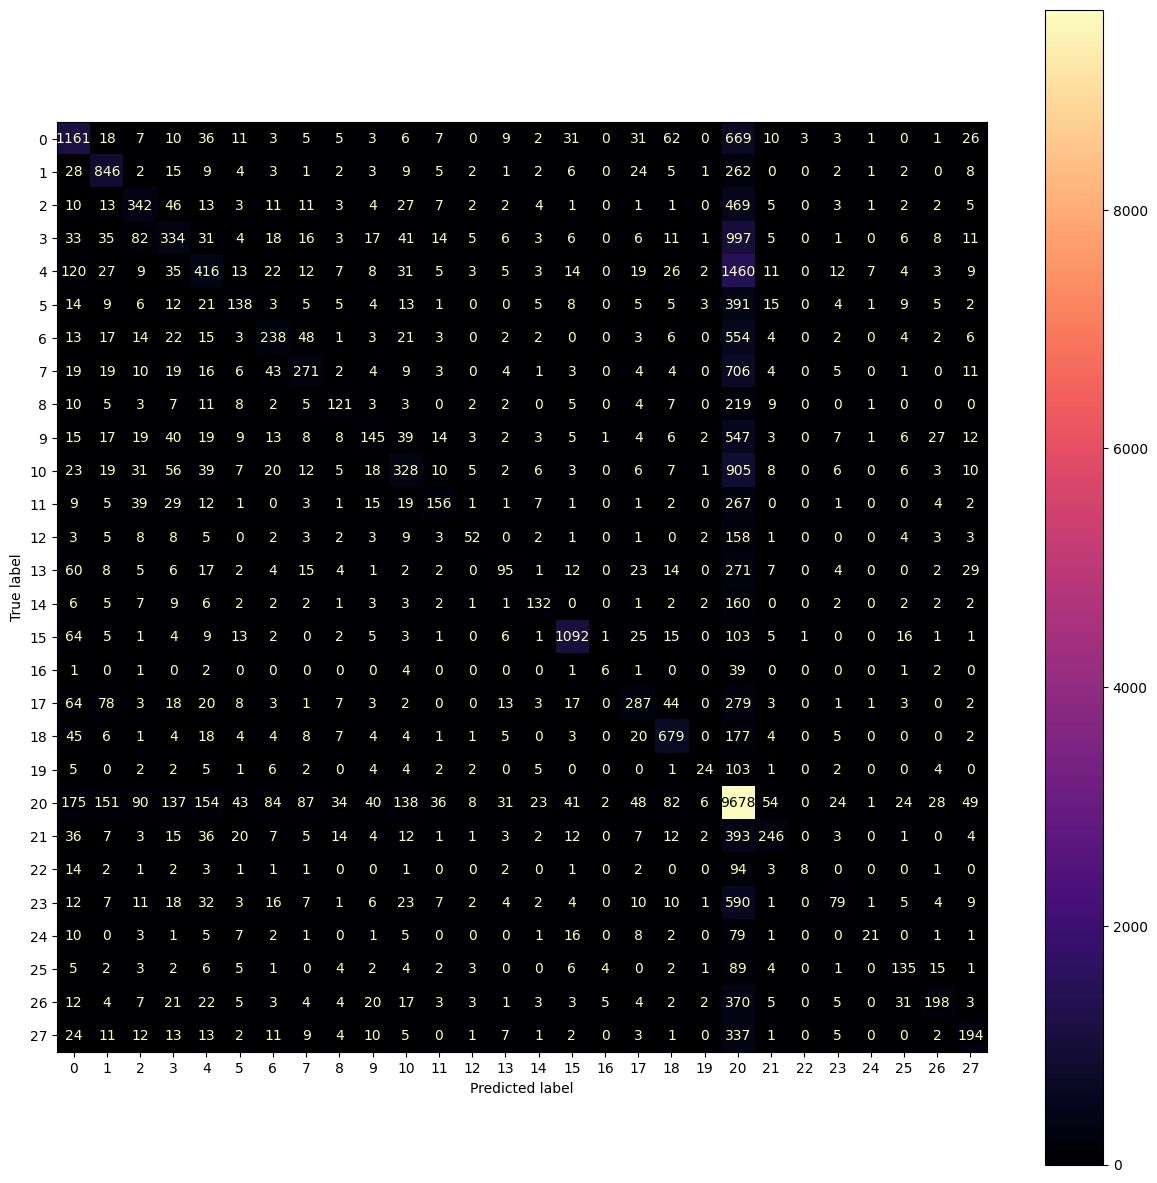

In [27]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Best estimator (Sentiment): DecisionTreeClassifier(max_depth=100, min_samples_split=5), Best Score: 0.515219404662324
Accuracy for Emotion: 0.6246944476778024
Precision (Weighted) for Emotion: 0.6694729663155291
F1 Score (Weighted) for Emotion: 0.6264256673637745
F1 Score (Macro) for Emotion: 0.5987656883395149
              precision    recall  f1-score   support

           0       0.53      0.45      0.49      3680
           1       0.69      0.50      0.58      7689
           2       0.51      0.79      0.62     11268
           3       0.85      0.60      0.70     11727

    accuracy                           0.62     34364
   macro avg       0.65      0.59      0.60     34364
weighted avg       0.67      0.62      0.63     34364



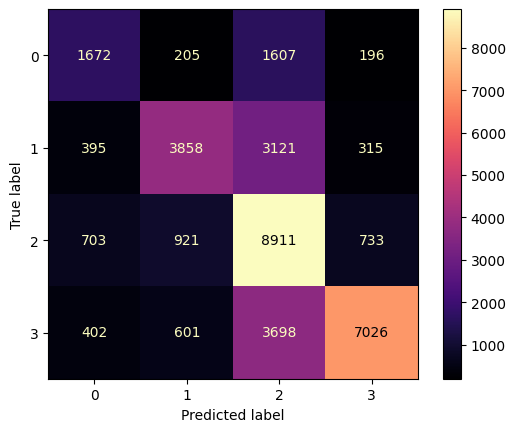

In [28]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron found using GridSearchCV</h2>

input parameter requires a model object

using the various value for the following parameters: activation, architectures, solvers
Hidden layers <a href="https://datascience.stackexchange.com/questions/19768/how-to-implement-pythons-mlpclassifier-with-gridsearchcv">Link</a>

<b>Unable to converge</b>


In [29]:
parameters = {"activation":("identity", "logistic", "tanh", "relu"),"hidden_layer_sizes":((5,5),(5,10)), "solver":("adam","sgd")}
#currently 5 neurons then 5 neurons and 5 neurons then 10 neurons in the hidden layer
clfMLP = MLPClassifier()
classifier = GridSearchCV(estimator=clfMLP, param_grid=parameters)
skip=True
if(not skip):
    if (os.path.exists('models/MLP1GridCV_model.pickle')):
        pickle_in = open('models/MLP1GridCV_model.pickle','rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train, yemo_train)
        with open('models/MLP1GridCV_model.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/MLP1GridCV_model.pickle','rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/MLP2GridCV_model.pickle')):
        pickle_in = open('models/MLP2GridCV_model.pickle','rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train,ysent_train)
        with open('models/MLP2GridCV_model.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/MLP2GridCV_model.pickle','rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

skipped


In [30]:
if (os.path.exists('models/MLP1GridCV_model.pickle') and not skip):
    y_emo_predict = clf1.best_estimator_.predict(X_test)
    metrics(yemo_test,y_emo_predict)
    print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
    metrics(yemo_test,y_emo_predict)
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
    fig, ax = plt.subplots(figsize=(15,15))
    cmp.plot(ax=ax,cmap='magma')
else:
    print("skipped")

skipped


In [31]:
if (os.path.exists('models/MLP2GridCV_model.pickle') and not skip):
    y_sent_predict = clf2.best_estimator_.predict(X_test)
    metrics(ysent_test,y_sent_predict)
    print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
    ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')
else:
    print("skipped")

skipped


<h3>2.5</h3>
Test/Training split: 80/20 -> 95/5
Anticipated effect: increased accuracy but poor generalization


In [32]:
post = file[0]
vectorizer = CountVectorizer()
#vectorize posts into words that were used
# file[0] = vectorizer.fit_transform(post)
X = vectorizer.fit_transform(file[0])
# X_features =vectorizer.get_feature_names_out()

leEmo = preprocessing.LabelEncoder()
leSent = preprocessing.LabelEncoder()
#list(le.inverse_transform([2, 2, 1]))
encodedEmo = leEmo.fit_transform(file[1])  #change 0 to the column of emotions with no separation
#vectorize sentiments
encodedSentiment = leSent.fit_transform(file[2])  #change 0 to the column of sentiment with no separation



In [33]:
X_train, X_test, yemo_train, yemo_test, ysent_train, ysent_test = train_test_split(X, encodedEmo, encodedSentiment,test_size=0.5, train_size=0.5)

<h2>Multinomial Naive Bayes Classifier (naive bayes.MultinomialNB.html) using new test train split</h2>

In [34]:
classifier = MultinomialNB()
if (os.path.exists('models/new_split/MNB1_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")

else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/MNB1_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/MNB2_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/MNB2_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


Score for Emotion: 0.450727505529042
Accuracy for Emotion: 0.450727505529042
Precision (Weighted) for Emotion: 0.49276793158770316


C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 Score (Weighted) for Emotion: 0.391712862531878
F1 Score (Macro) for Emotion: 0.25216201059031523


C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       0.55      0.55      0.55      5210
           1       0.61      0.43      0.51      3025
           2       0.54      0.22      0.31      2604
           3       0.43      0.17      0.25      4160
           4       0.46      0.18      0.26      5613
           5       0.45      0.14      0.21      1742
           6       0.54      0.12      0.20      2527
           7       0.57      0.20      0.29      2982
           8       0.57      0.07      0.13      1082
           9       0.55      0.10      0.17      2371
          10       0.45      0.17      0.25      3886
          11       0.57      0.16      0.25      1433
          12       0.56      0.04      0.07       680
          13       0.56      0.09      0.16      1503
          14       0.69      0.10      0.17       892
          15       0.76      0.74      0.75      3503
          16       0.00      0.00      0.00       170
          17       0.50    

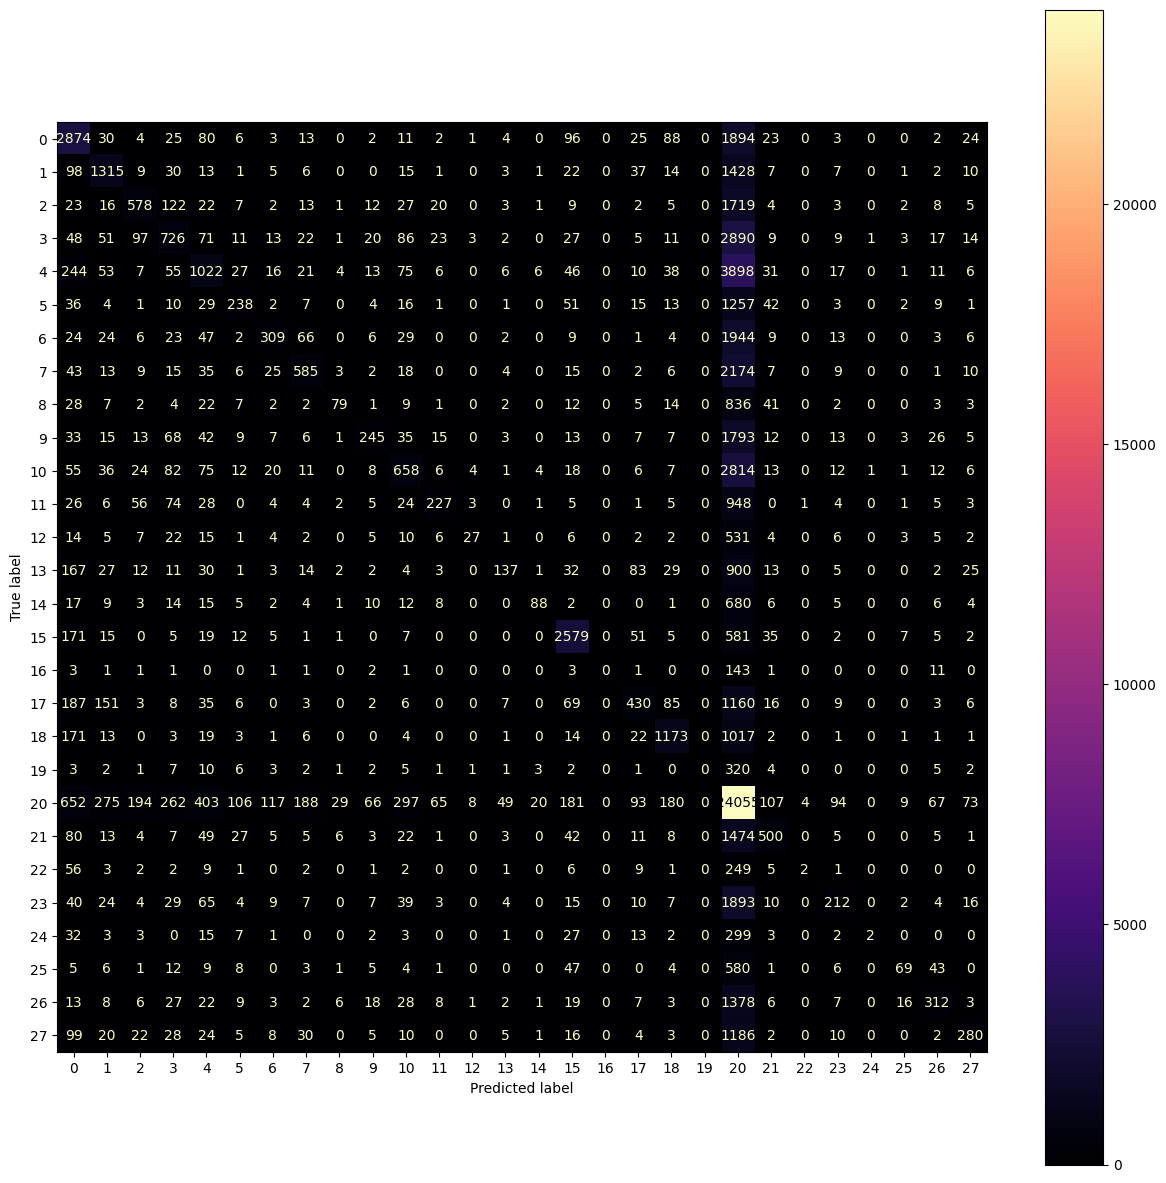

In [35]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test, yemo_test)}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')

Score for Sentiment: 0.6147130718193459
Accuracy for Emotion: 0.6147130718193459
Precision (Weighted) for Emotion: 0.6097085873809802
F1 Score (Weighted) for Emotion: 0.608715959012397
F1 Score (Macro) for Emotion: 0.5772792084182458
              precision    recall  f1-score   support

           0       0.55      0.34      0.42      9673
           1       0.61      0.61      0.61     19288
           2       0.57      0.57      0.57     27594
           3       0.66      0.75      0.70     29355

    accuracy                           0.61     85910
   macro avg       0.60      0.57      0.58     85910
weighted avg       0.61      0.61      0.61     85910



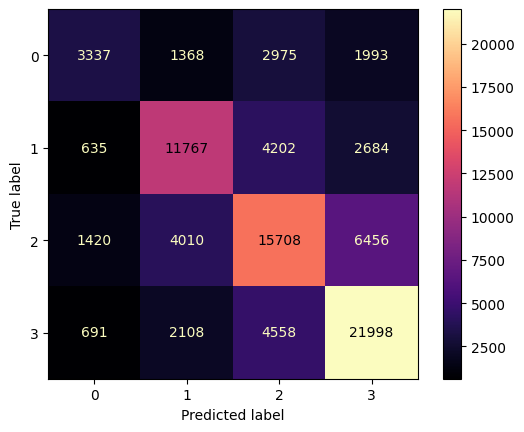

In [36]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test, ysent_test)}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Decision Tree (tree.DecisionTreeClassifier) using new test train split</h2>

In [37]:
classifier = DecisionTreeClassifier()
if (os.path.exists('models/new_split/DT1_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/DT1_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)
    pickle_in = open('models/new_split/DT1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/DT2_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/DT2_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)
    pickle_in = open('models/new_split/DT2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


Score for Emotion: 0.6225235711791409
Accuracy for Emotion: 0.6225235711791409
Precision (Weighted) for Emotion: 0.6334985861839494
F1 Score (Weighted) for Emotion: 0.6168956763722442
F1 Score (Macro) for Emotion: 0.5396532119961878
              precision    recall  f1-score   support

           0       0.60      0.84      0.70      5210
           1       0.59      0.82      0.68      3025
           2       0.49      0.72      0.58      2604
           3       0.42      0.58      0.49      4160
           4       0.48      0.55      0.52      5613
           5       0.50      0.59      0.54      1742
           6       0.52      0.56      0.54      2527
           7       0.60      0.62      0.61      2982
           8       0.54      0.52      0.53      1082
           9       0.50      0.45      0.47      2371
          10       0.59      0.49      0.54      3886
          11       0.60      0.43      0.50      1433
          12       0.53      0.37      0.43       680
          

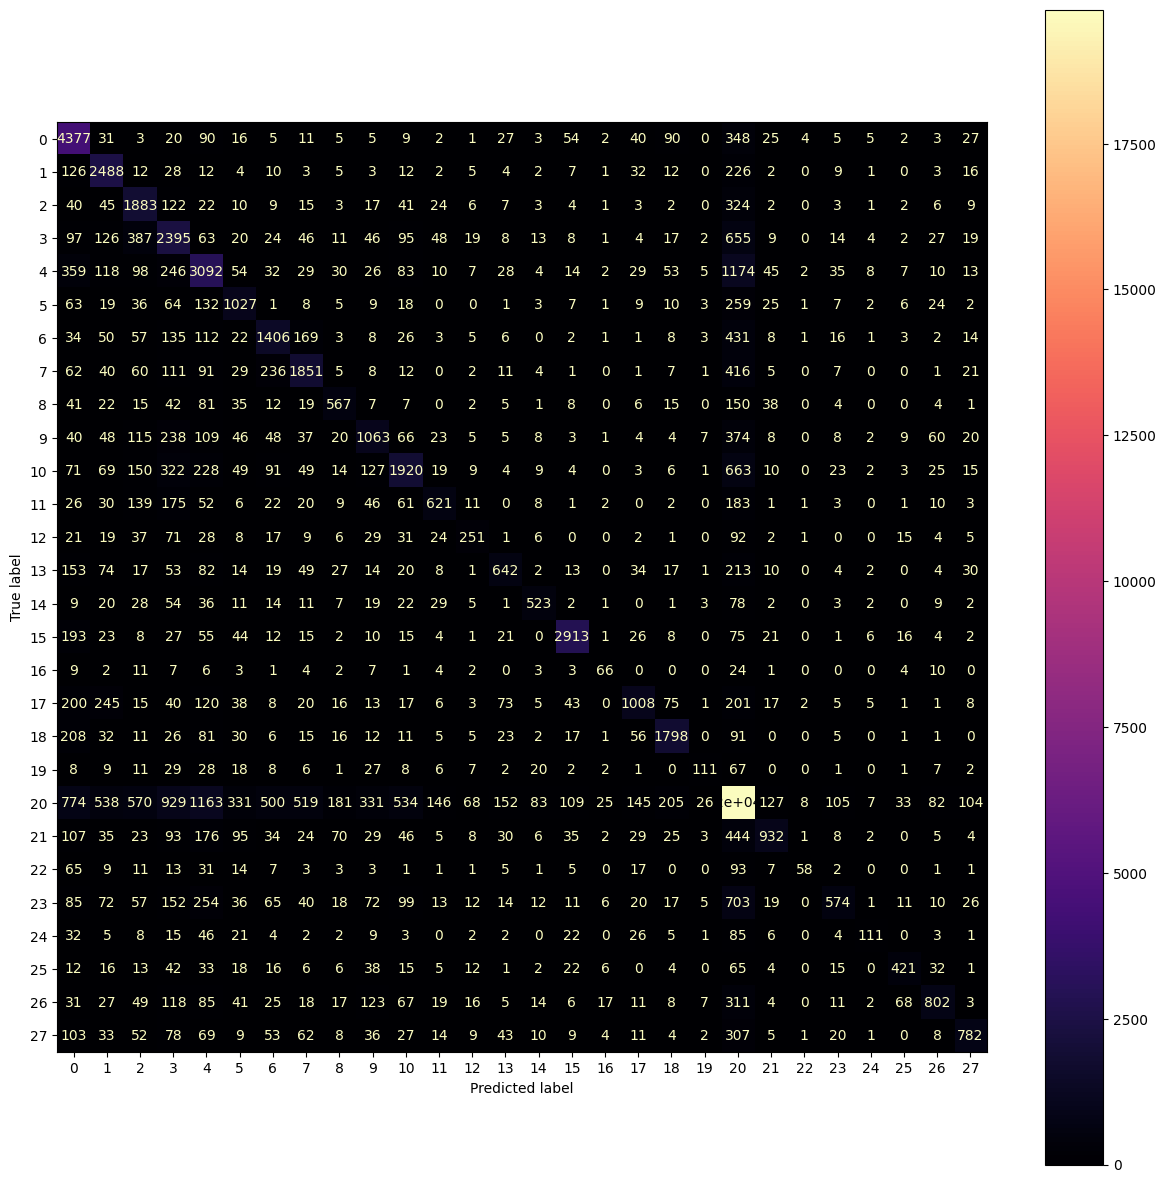

In [38]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test, yemo_test)}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')

Score for Sentiment: 0.7399022232568968
Accuracy for Emotion: 0.7399022232568968
Precision (Weighted) for Emotion: 0.7468772059153584
F1 Score (Weighted) for Emotion: 0.7415372114438689
F1 Score (Macro) for Emotion: 0.7268301589972691
              precision    recall  f1-score   support

           0       0.61      0.71      0.66      9673
           1       0.70      0.78      0.74     19288
           2       0.73      0.70      0.71     27594
           3       0.84      0.76      0.80     29355

    accuracy                           0.74     85910
   macro avg       0.72      0.74      0.73     85910
weighted avg       0.75      0.74      0.74     85910



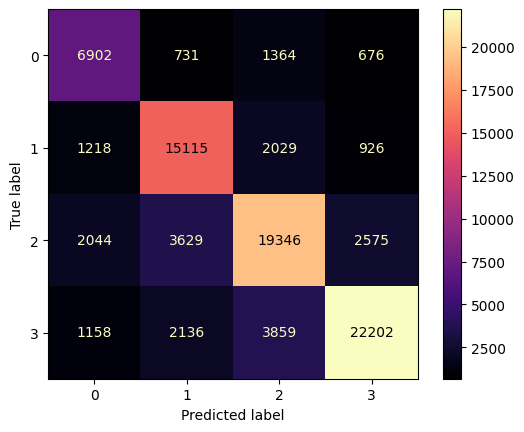

In [39]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test, ysent_test)}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron (neural network.MLPClassifier) using new test train split</h2>

<b>Did not converge timed out</b>

In [40]:
classifier = MLPClassifier()
skip=False
if(not skip):
    if (os.path.exists('models/new_split/MLP1_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP1_model_new_split.pickle', 'rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        MLP1 = classifier.fit(X_train, yemo_train)
        with open('models/new_split/MLP1_model_new_split.pickle', 'wb') as f:
            pickle.dump(classifier, f)
        pickle_in = open('models/new_split/MLP1_model_new_split.pickle', 'rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/new_split/MLP2_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP2_model_new_split.pickle', 'rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        MLP2 = classifier.fit(X_train, ysent_train)
        with open('models/new_split/MLP2_model_new_split.pickle', 'wb') as f:
            pickle.dump(classifier, f)
        pickle_in = open('models/new_split/MLP2_model_new_split.pickle', 'rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


pickle file used
pickle file used


Score for Emotion: 0.5978582237225003
Accuracy for Emotion: 0.5978582237225003
Precision (Weighted) for Emotion: 0.5897283422998468
F1 Score (Weighted) for Emotion: 0.5891022694917816
F1 Score (Macro) for Emotion: 0.520869913953311
              precision    recall  f1-score   support

           0       0.65      0.73      0.69      5210
           1       0.64      0.69      0.67      3025
           2       0.60      0.47      0.53      2604
           3       0.48      0.39      0.43      4160
           4       0.54      0.37      0.44      5613
           5       0.53      0.48      0.50      1742
           6       0.56      0.39      0.46      2527
           7       0.58      0.57      0.57      2982
           8       0.47      0.55      0.51      1082
           9       0.51      0.36      0.42      2371
          10       0.53      0.47      0.50      3886
          11       0.50      0.48      0.49      1433
          12       0.41      0.51      0.45       680
          1

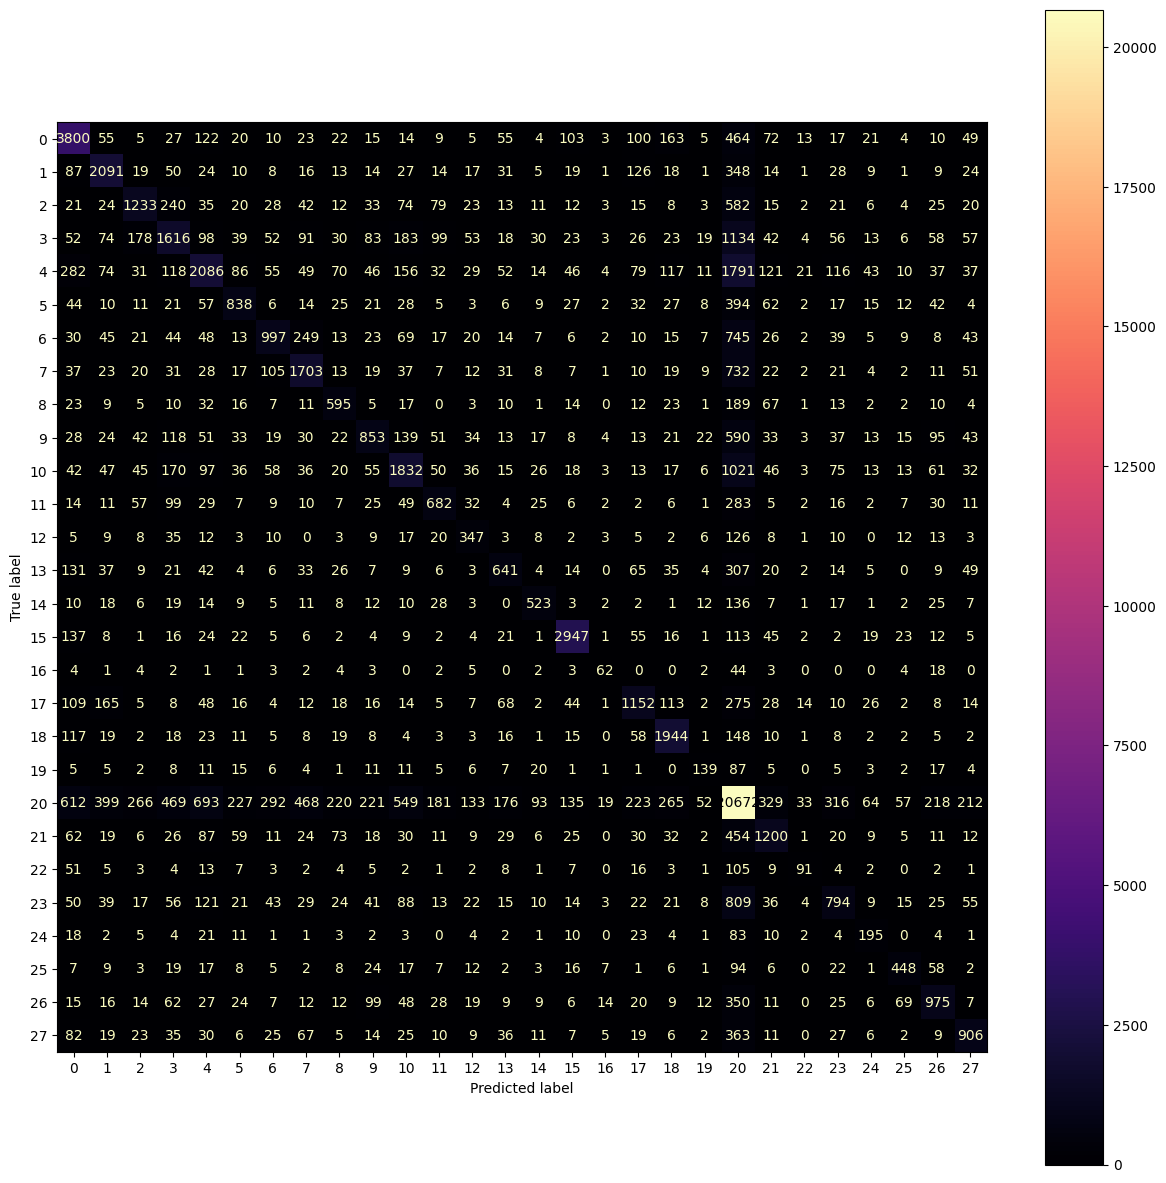

In [41]:

if (os.path.exists('models/new_split/MLP1_model_new_split.pickle') and not skip):
    y_emo_predict = clf1.predict(X_test)
    print(f"Score for Emotion: {clf1.score(X_test, yemo_test)}")
    metrics(yemo_test, y_emo_predict)
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
    fig, ax = plt.subplots(figsize=(15, 15))
    cmp.plot(ax=ax, cmap='magma')
else:
    print("skipped")

Score for Sentiment: 0.7255616342684205
Accuracy for Emotion: 0.7255616342684205
Precision (Weighted) for Emotion: 0.7245487269538259
F1 Score (Weighted) for Emotion: 0.7247724138597249
F1 Score (Macro) for Emotion: 0.7051989019585782
              precision    recall  f1-score   support

           0       0.65      0.58      0.61      9673
           1       0.71      0.73      0.72     19288
           2       0.70      0.70      0.70     27594
           3       0.79      0.80      0.79     29355

    accuracy                           0.73     85910
   macro avg       0.71      0.70      0.71     85910
weighted avg       0.72      0.73      0.72     85910



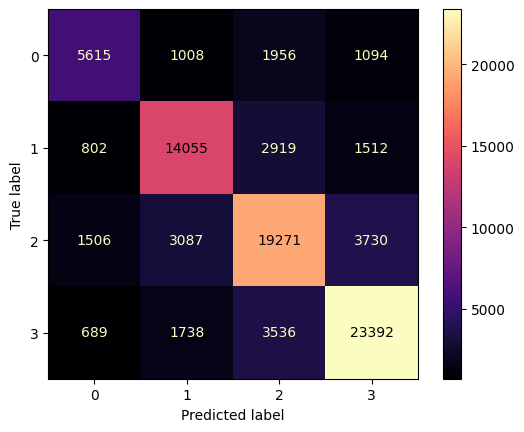

In [42]:
if (os.path.exists('models/new_split/MLP1_model_new_split.pickle') and not skip):
    y_sent_predict = clf2.predict(X_test)

    print(f"Score for Sentiment: {clf2.score(X_test, ysent_test)}")
    metrics(ysent_test, y_sent_predict)
    ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')
else:
    print("skipped")

<h2>Multinomial Naive Bayes Classifier found using GridSearchCV and new test train split</h2>

input parameter requires a model object

using the following alpha parameters 0.5,0,0.36,1

In [43]:
parameters = {"alpha": (0.5, 0, 0.36, 1)}
clfMNB = MultinomialNB()

classifier = GridSearchCV(estimator=clfMNB, param_grid=parameters, n_jobs=-1)

if (os.path.exists('models/new_split/MNB1GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/MNB1GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/MNB2GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/MNB2GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


Best estimator (Emotion): MultinomialNB(alpha=0.5), Best Score: 0.3905984755012737
Accuracy for Emotion: 0.4857292515423117
Precision (Weighted) for Emotion: 0.4886816498563165
F1 Score (Weighted) for Emotion: 0.4549197369163101
F1 Score (Macro) for Emotion: 0.3462775052223591
              precision    recall  f1-score   support

           0       0.54      0.62      0.58      5210
           1       0.59      0.60      0.60      3025
           2       0.51      0.35      0.41      2604
           3       0.41      0.24      0.30      4160
           4       0.42      0.23      0.30      5613
           5       0.39      0.28      0.33      1742
           6       0.46      0.23      0.31      2527
           7       0.51      0.31      0.39      2982
           8       0.55      0.21      0.30      1082
           9       0.46      0.19      0.27      2371
          10       0.43      0.27      0.33      3886
          11       0.51      0.27      0.35      1433
          12       

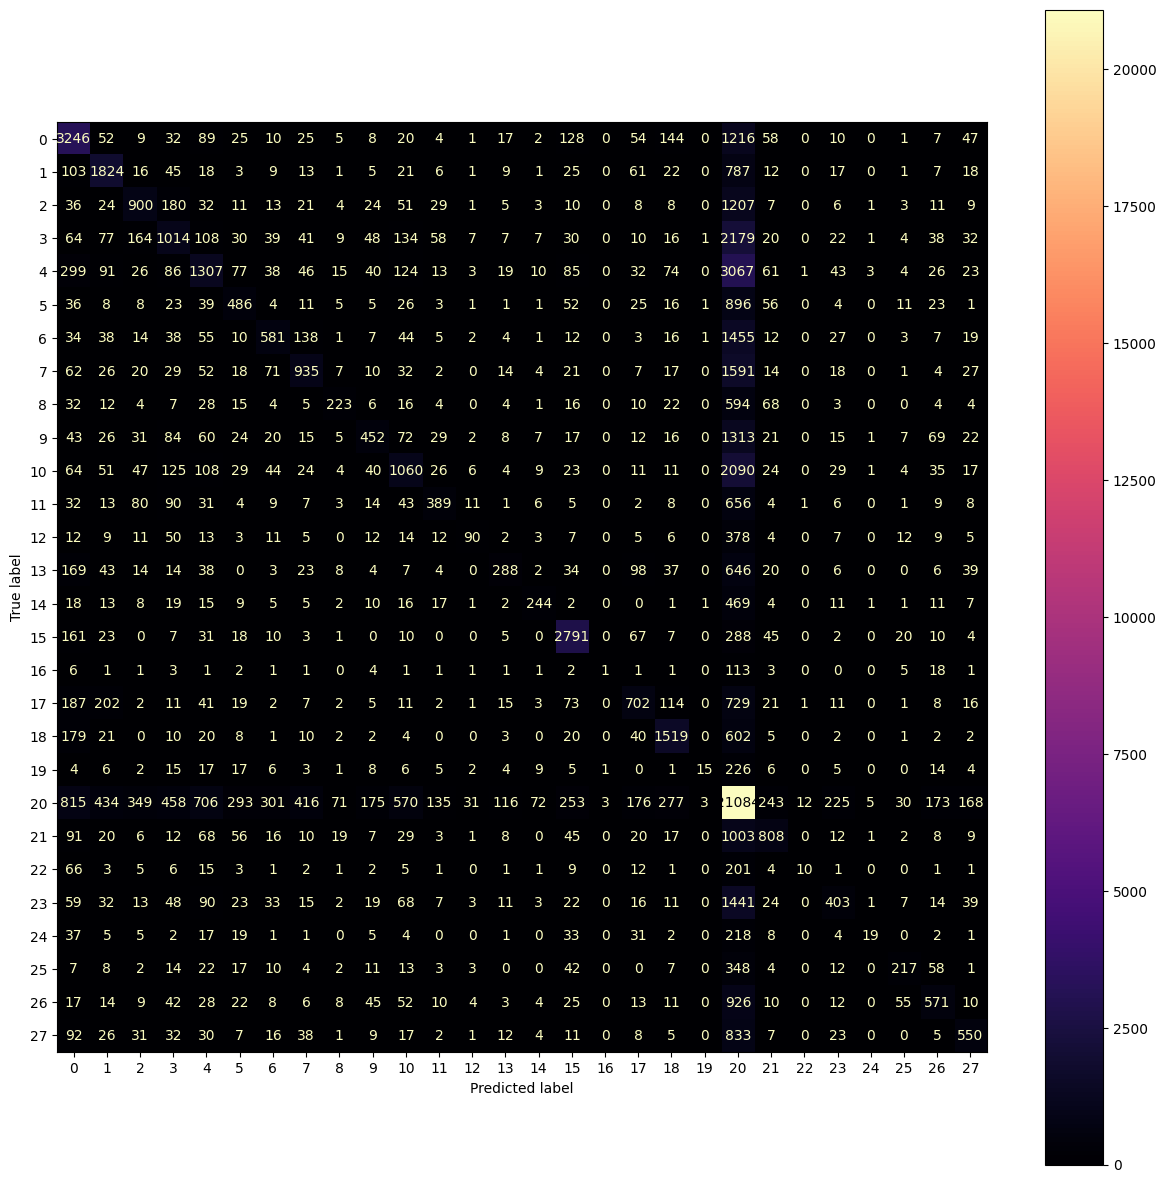

In [44]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')


Best estimator (Sentiment): MultinomialNB(alpha=1), Best Score: 0.543696292227927
Accuracy for Emotion: 0.6147130718193459
Precision (Weighted) for Emotion: 0.6097085873809802
F1 Score (Weighted) for Emotion: 0.608715959012397
F1 Score (Macro) for Emotion: 0.5772792084182458
              precision    recall  f1-score   support

           0       0.55      0.34      0.42      9673
           1       0.61      0.61      0.61     19288
           2       0.57      0.57      0.57     27594
           3       0.66      0.75      0.70     29355

    accuracy                           0.61     85910
   macro avg       0.60      0.57      0.58     85910
weighted avg       0.61      0.61      0.61     85910



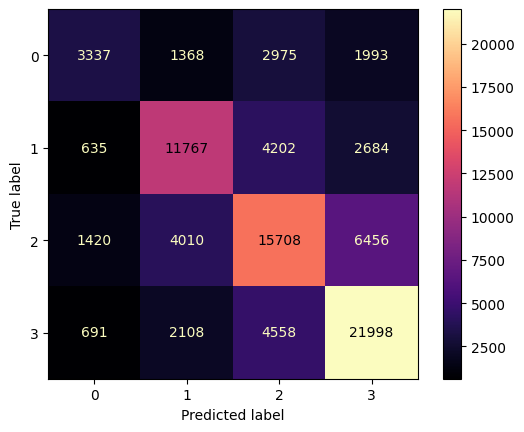

In [45]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>DecisionTree Classifier found using GridSearchCV and new test train split </h2>

input parameter requires a model object

using the various value for the following parameters: criterion, max_depth, min_samples

In [46]:
parameters = {"criterion": ("gini", "entropy"), "max_depth": (100, 3), "min_samples_split": (12, 5, 30)}
clfDT = DecisionTreeClassifier()

classifier = GridSearchCV(estimator=clfDT, param_grid=parameters, n_jobs=-1)

if (os.path.exists('models/new_split/DT1GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/DT1GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/DT1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/DT2GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/DT2GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/DT2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


Best estimator (Emotion): DecisionTreeClassifier(max_depth=100, min_samples_split=30), Best Score: 0.3984285880572692
Accuracy for Emotion: 0.4663135839832383
Precision (Weighted) for Emotion: 0.4555090597064612
F1 Score (Weighted) for Emotion: 0.4201667586101534
F1 Score (Macro) for Emotion: 0.31919625608172264
              precision    recall  f1-score   support

           0       0.54      0.51      0.53      5210
           1       0.56      0.58      0.57      3025
           2       0.44      0.27      0.33      2604
           3       0.29      0.16      0.20      4160
           4       0.33      0.14      0.20      5613
           5       0.34      0.14      0.20      1742
           6       0.40      0.20      0.27      2527
           7       0.46      0.22      0.30      2982
           8       0.44      0.27      0.34      1082
           9       0.34      0.13      0.19      2371
          10       0.33      0.15      0.20      3886
          11       0.45      0.22    

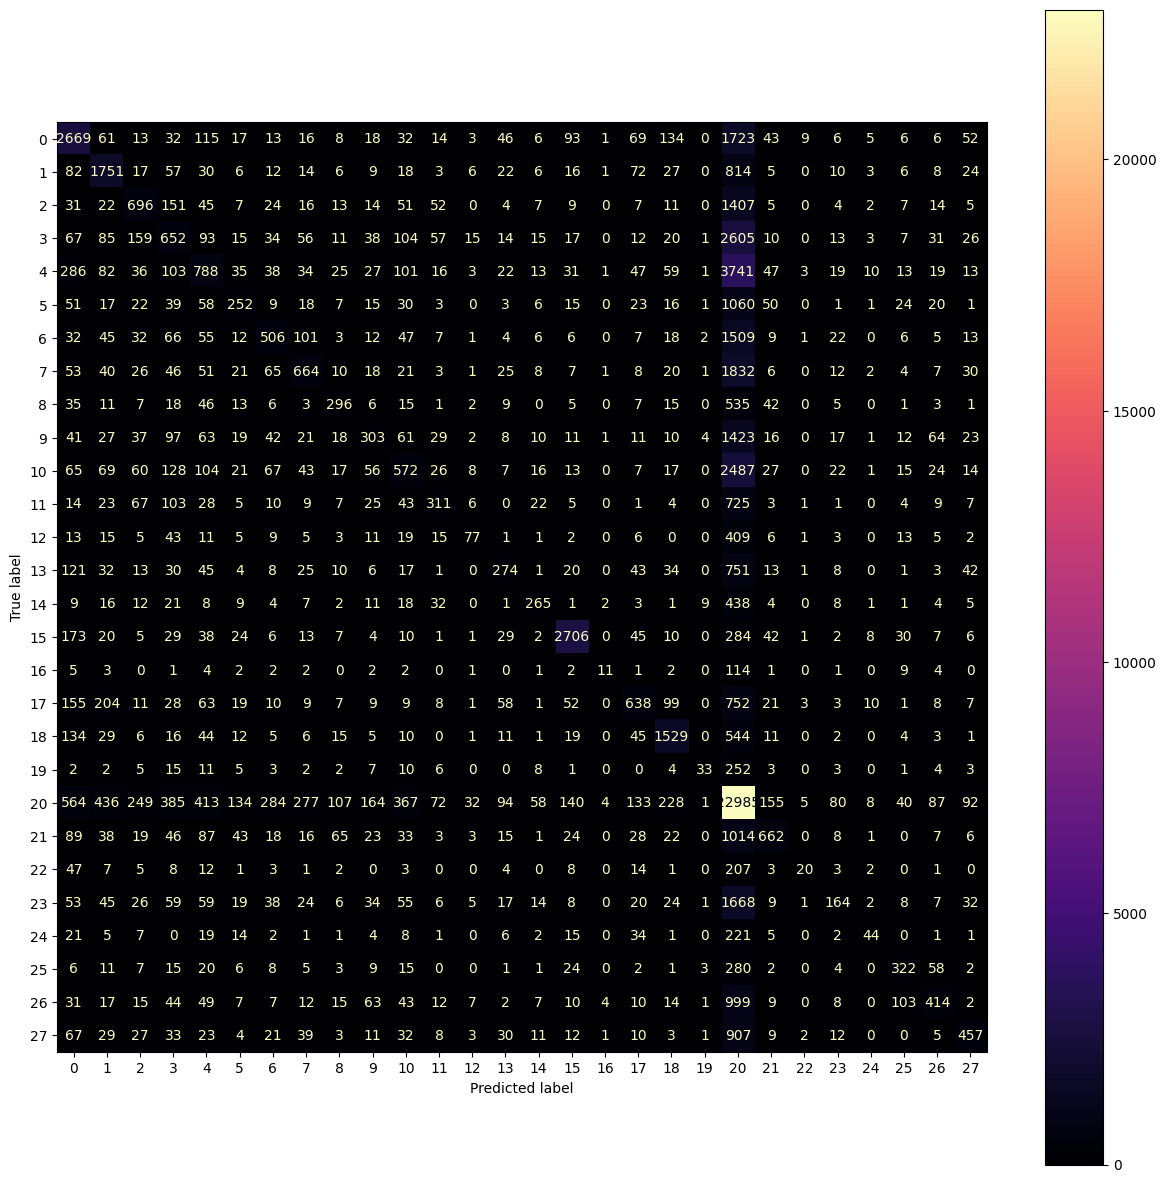

In [47]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')


Best estimator (Sentiment): DecisionTreeClassifier(max_depth=100, min_samples_split=5), Best Score: 0.49976719823070653
Accuracy for Emotion: 0.5814806192527063
Precision (Weighted) for Emotion: 0.6271879498813887
F1 Score (Weighted) for Emotion: 0.5796411594508462
F1 Score (Macro) for Emotion: 0.5474686347747831
              precision    recall  f1-score   support

           0       0.52      0.34      0.41      9673
           1       0.64      0.44      0.53     19288
           2       0.47      0.78      0.59     27594
           3       0.80      0.57      0.66     29355

    accuracy                           0.58     85910
   macro avg       0.61      0.53      0.55     85910
weighted avg       0.63      0.58      0.58     85910



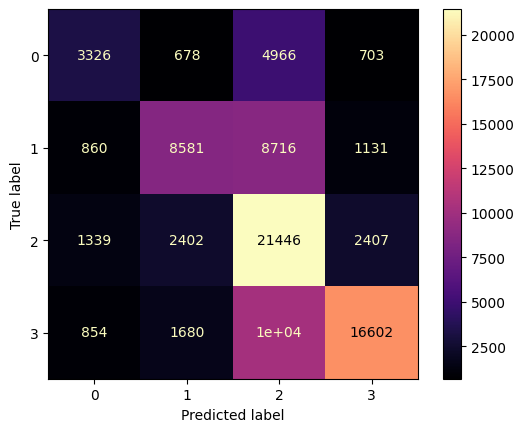

In [48]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron found using GridSearchCV and new test train split</h2>

input parameter requires a model object

using the various value for the following parameters: activation, architectures, solvers
Hidden layers <a href="https://datascience.stackexchange.com/questions/19768/how-to-implement-pythons-mlpclassifier-with-gridsearchcv">Link</a>

<b>Unable to converge</b>


In [49]:
parameters = {"activation":("identity", "logistic", "tanh", "relu"),"hidden_layer_sizes":((5,5),(5,10)), "solver":("adam","sgd")}
#currently 5 neurons then 5 neurons and 5 neurons then 10 neurons in the hidden layer
clfMLP = MLPClassifier()
classifier = GridSearchCV(estimator=clfMLP, param_grid=parameters)
skip=True
if(not skip):
    if (os.path.exists('models/new_split/MLP1GridCV_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP1GridCV_model_new_split.pickle','rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train, yemo_train)
        with open('models/new_split/MLP1GridCV_model_new_split.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP1GridCV_model_new_split.pickle','rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/new_split/MLP2GridCV_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP2GridCV_model_new_split.pickle','rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train,ysent_train)
        with open('models/new_split/MLP2GridCV_model_new_split.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP2GridCV_model_new_split.pickle','rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

skipped


In [50]:
if (os.path.exists('models/new_split/MLP1GridCV_model_new_split.pickle') and not skip):
    y_emo_predict = clf1.best_estimator_.predict(X_test)
    metrics(yemo_test,y_emo_predict)
    print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
    metrics(yemo_test,y_emo_predict)
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
    fig, ax = plt.subplots(figsize=(15,15))
    cmp.plot(ax=ax,cmap='magma')
else:
    print("skipped")

skipped


In [51]:
if (os.path.exists('models/new_split/MLP2GridCV_model_new_split.pickle') and not skip):
    y_sent_predict = clf2.best_estimator_.predict(X_test)
    metrics(ysent_test,y_sent_predict)
    print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
    ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')
else:
    print("skipped")

skipped


<h3>3. Embedding as features</h3>

requires install of library gensim

pip install gensim

https://radimrehurek.com/gensim/models/word2vec.html


In [52]:
# result.most_similar("cat")

In [53]:
if (os.path.exists('models/word2vec.pickle')):
    pickle_in = open('models/word2vec.pickle','rb')
    word2vec = pickle.load(pickle_in)
    print("pickle file used")
else:
    model =gensim.downloader.load("word2vec-google-news-300")
    with open('models/word2vec.pickle','wb') as f:
        pickle.dump(model, f)

    pickle_in = open('models/word2vec.pickle','rb')
    word2vec = pickle.load(pickle_in)

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [54]:
nltk.download('punkt')
tokenized_word = [word_tokenize(i) for i in post]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\girou\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [81]:
post_tokens = [post_tokens for post_tokens in tokenized_word] #http://librarycarpentry.org/lc-tdm/aio/index.html
num_tokens = 0
print("Number of tokens in Reddit posts:")
for i in post_tokens:
    num_tokens=num_tokens+len(i)
print(num_tokens)

Number of tokens in Reddit posts:
2642128
